## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

參考文件
https://morvanzhou.github.io/tutorials/machine-learning/keras/3-1-save/

In [1]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5",    # path to save
                             monitor="val_loss",     # target to monitor
                             save_best_only=True)    # save best checkpoint

In [8]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 5s 100us/step - loss: 0.5531 - accuracy: 0.8394 - val_loss: 1.6145 - val_accuracy: 0.4960
Epoch 47/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.5369 - accuracy: 0.8450 - val_loss: 1.6444 - val_accuracy: 0.4943
Epoch 48/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.5207 - accuracy: 0.8517 - val_loss: 1.6605 - val_accuracy: 0.4926
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.5040 - accuracy: 0.8584 - val_loss: 1.6655 - val_accuracy: 0.4907
Epoch 50/50
10000/10000 [==============================] - 1s 94us/step


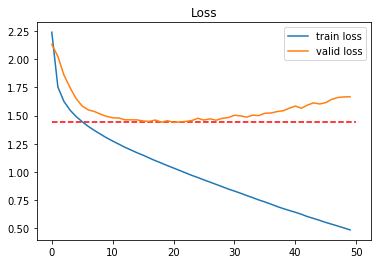

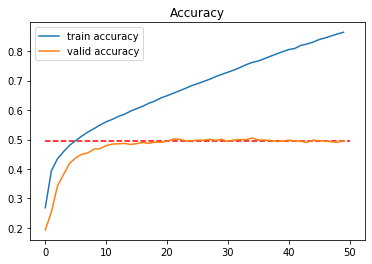

In [9]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')   #以 y=loss_loadback畫出水平分割線
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')    #以 y=acc_loadback畫出水平分割線
plt.legend()
plt.title("Accuracy")
plt.show()


In [10]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5",    # path to save
                             monitor="val_loss",     # target to monitor
                             save_best_only=False)    # save best checkpoint

In [11]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

50000/50000 [==============================] - 5s 100us/step - loss: 0.5657 - accuracy: 0.8320 - val_loss: 1.6095 - val_accuracy: 0.4896
Epoch 47/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.5487 - accuracy: 0.8380 - val_loss: 1.6470 - val_accuracy: 0.4861
Epoch 48/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.5334 - accuracy: 0.8446 - val_loss: 1.6467 - val_accuracy: 0.4862
Epoch 49/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.5150 - accuracy: 0.8520 - val_loss: 1.6606 - val_accuracy: 0.4878
Epoch 50/50
10000/10000 [==============================] - 1s 93us/step


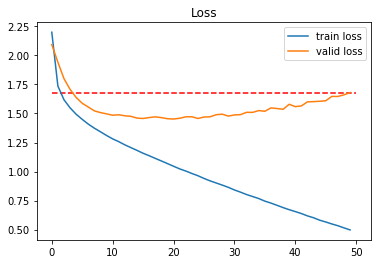

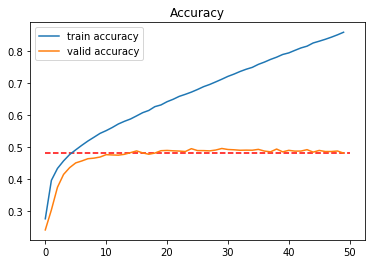

In [12]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')    #以 y=loss_loadback畫出水平分割線
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')     #以 y=acc_loadback畫出水平分割線
plt.legend()
plt.title("Accuracy")
plt.show()